# Frequent itemsets in the Yelp reviwes dataset

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "XXXXXXX"
os.environ['KAGGLE_KEY'] = "XXXXXXX"
!kaggle datasets download -d yelp-dataset/yelp-dataset
!unzip yelp-dataset.zip "yelp_academic_dataset_review.json"

100% 4.07G/4.07G [00:45<00:00, 47.4MB/s]
100% 4.07G/4.07G [00:45<00:00, 95.6MB/s]
Archive:  yelp-dataset.zip
  inflating: yelp_academic_dataset_review.json  


In [2]:
import json
import nltk
import random
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import defaultdict
from itertools import combinations
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Preprocessing

Each basket is built starting from the **text** field in the yelp reviews.
We use words as items (excluding stopwords) which are mapped to integers.

A couple of utils functions is defined to retrieve words from reviews






In [3]:
#remove all non-alphanumeric characters from the beginning and the end of a word
def strip_word(word: str):
    start = 0
    end = len(word) - 1
    while start < len(word) and not word[start].isalpha(): start += 1
    while (not word[end].isalpha() and start < end): end -= 1
    return word[start : end+1]

#returns a list of token from a string
def tokenize(text: str):
    _stopwords = stopwords.words("english")
    _stopwords.extend(["i'm", "i've", "us", "got", "would", "could", "i'll"])
    tokens = [strip_word(word.lower()) for word in text.split()]
    tokens = list(filter(lambda x: x != "" and x not in _stopwords, tokens))
    return tokens


A class to encode/decode the items

In [4]:
class EncodeItems:

    """
    This class converts uniquely strings to integers
    """

    def __init__(self):
        self.items2number = dict()
        self.number2items = dict()
        self.counter = 0

    def encode(self, item: str):
        if item in self.items2number:   #item already encoded
            return self.items2number[item]
        self.counter += 1
        self.items2number[item] = self.counter
        self.number2items[self.counter] = item
        return self.counter

    def decode(self, number: int):
        return self.number2items[number]

    def size(self):
        return self.counter



In [5]:
filename = "baskets.json"
basket_file = "baskets.json"
sample_file = "baskets_small.json"

### Subset extraction

For presentation purposes a portion of the dataset is extracted and saved for making the execution replicable in less time. Also we save a second file (smaller) as sample for the second part.

We don't take just the first portion of the file but we scan all file and pick a line with a defined probability p.

For run it in a reasonable amount of time we take 1/100 of the original kaggle dataset.

Using 1/10 of the data it will take more or less 1 hour to finish

In [6]:
N = 1000 #(exec time 10)

#use this to take a bigger dataset and a bigger sample (exec time 1 hour)
#N=100

In [7]:
item_to_number = EncodeItems()
#keep track of sizes
size = 0
sample_size = 0
with open("yelp_academic_dataset_review.json") as input_file:
    with open(basket_file, "w") as output_file:
        with open(sample_file, "w") as output_file2:
            for line in input_file:
                n = random.randint(1, N)
                if n <= 10:
                    size += 1
                    review = json.loads(line)
                    #baskets are saved encoded
                    basket = [item_to_number.encode(item) for item in set(tokenize(review['text']))]
                    output_file.write(json.dumps(sorted(basket)) + "\n")
                    if n <= 1:
                        output_file2.write(json.dumps(sorted(basket)) + "\n")
                        sample_size += 1
size, sample_size

(69862, 6944)

In [8]:
s = 0.02    #support threshold

In [9]:
"""
generates the candidates of size k from the set of frequent itemsets of size k-1
combining the k-1 itemsets with themselves and filtering out the ones that don't
respect the monotonicity property
"""
def generate_candidates(L, k):

    candidates = []

    for i in range(len(L)):
        for j in range(i+1, len(L)):
            if L[i][:k-2] == L[j][:k-2]:    #they match on the first k-1 items
                candidate = L[i] + (L[j][k-2],)
                is_candidate = True
                #excludes the ones that don't respect the monotonicity property
                for comb in combinations(candidate, k-1):
                    if comb not in L:
                        is_candidate = False
                        break
                if is_candidate:
                    candidates.append(candidate)
    return sorted(candidates)

def is_contained(subset, _set):
    for item in subset:
        if item not in _set:
            return False
    return True

#read the input file to count the actual frequence of each candidate (support value)
def frequences(candidates, L1, filename):
    counts = defaultdict(lambda: 0)
    if candidates == []:
        return counts

    with open(filename) as file:
        i = 0
        for line in file:
            #if i % 100 == 0: print(i)
            i+=1
            #we consider only the frequent singletons
            basket = {item for item in json.loads(line) if item in L1}
            for candidate in candidates:
                if is_contained(candidate, basket):
                    counts[candidate] += 1
    return counts

#return the list of frequent itemsets based on the support threshold s
def extract_frequents(items, s, neg_border=False):
    res = []
    negative_border = []
    for item, count in items.items():
        if count >= s:
            res.append(item)
        elif neg_border:
            negative_border.append(item)
    if neg_border:
        return sorted(res), negative_border
    return sorted(res)



### The Algorithm

We first compute the frequent sigletons scanning the entire file and we use them to generate the candidates pairs and from them extract just the ones that are above the thresold.

We separate them from the rest of computation beacuse we treat them in a slightly different way

In [10]:
#scan the files to extract the frequent one-item sets
def get_frequent_singletons(filname, s):
    item_counts = defaultdict(lambda: 0)
    with open(filename) as file:
        for line in file:
            basket = json.loads(line)
            for item in basket:
                item_counts[item] += 1

    L1 = extract_frequents(item_counts, s)
    return [(item,) for item in L1], item_counts

In [11]:
def get_frequent_pairs(filename, s, L1, neg_border=False):
    item_counts = defaultdict(lambda: 0)
    candidate_pairs = defaultdict(lambda: 0)
    with open(filename) as file:
        for line in file:
            basket = json.loads(line)
            frequent_in_basket = [item for item in basket if item in L1]
            #we generate Ck in a double for loop
            for i in range(len(frequent_in_basket)):
                for j in range(i+1, len(frequent_in_basket)):
                    candidate_pairs[tuple(sorted((frequent_in_basket[i], frequent_in_basket[j])))] += 1
    if neg_border:
        L2, n_b = extract_frequents(candidate_pairs, s, neg_border=True)
    else:
        L2 = extract_frequents(candidate_pairs, s)
    #we keep pairs sorted to simplify the condidates computation of C3
    if neg_border:
        return sorted(L2), n_b
    return sorted(L2)

In [12]:
frequent_items = {}

L1, counts = get_frequent_singletons(basket_file, s * size)
frequent_items[1] = L1
print(f'L1 contains {len(L1)} sets')

L1 contains 430 sets


Before computing the frequent pairs we check that the threshold is well-chosen.
We plot the frequences and thr two considered options: 1% and 2% showing that the latter leads to a sharper separation.

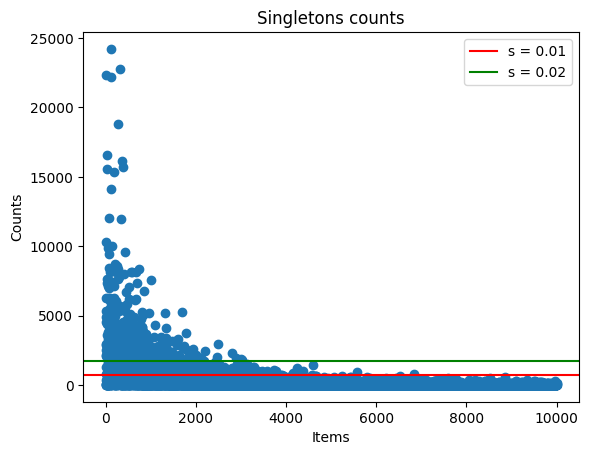

In [13]:

sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

# Estrai le chiavi e i valori ordinati
labels = [item[0] for item in sorted_counts if item[0] <= 10000]
values = [item[1] for item in sorted_counts if item[0] <= 10000]
plt.scatter(labels, values)
plt.axhline(0.01 * size, color="r", label="s = 0.01")
plt.axhline(0.025 * size, color="g", label="s = 0.02")
plt.xlabel('Items')
plt.ylabel('Counts')
plt.title('Singletons counts')
plt.legend()

plt.show()

In [14]:
L2 = get_frequent_pairs(basket_file, s * size, [item[0] for item in L1])
frequent_items[2] = L2
print(f'L2 contains {len(L2)} sets')

Lk_1 = L2
for k in range(3, 10):
    Ck = generate_candidates(Lk_1, k)
    counts = frequences(Ck, [item[0] for item in L1], filename)
    Lk = extract_frequents(counts, s * size)
    print(f'L{k} contains {len(Lk)} sets')
    if len(Lk) == 0:
        break
    Lk_1 = Lk
    frequent_items[k] = Lk

L2 contains 1349 sets
L3 contains 405 sets
L4 contains 9 sets
L5 contains 0 sets


Let's see soome of the reuslts

In [15]:
for i in range(1, 5):
    print(f'size {i}\n{[[item_to_number.decode(item) for item in fr_set] for fr_set in frequent_items[i][:10]]}\n')

size 1
[['fast'], ['best'], ['another'], ['days'], ['ask'], ['good'], ['took'], ['year'], ['old'], ['way']]

size 2
[['best', 'good'], ['best', 'time'], ['best', 'like'], ['best', 'staff'], ['best', 'really'], ['best', 'even'], ['best', 'well'], ['best', 'amazing'], ['best', 'great'], ['best', 'food']]

size 3
[['best', 'good', 'food'], ['best', 'good', 'place'], ['best', 'great', 'food'], ['best', 'great', 'place'], ['best', 'food', 'service'], ['best', 'food', 'place'], ['good', 'much', 'food'], ['good', 'much', 'place'], ['good', 'time', 'like'], ['good', 'time', 'really']]

size 4
[['good', 'time', 'food', 'place'], ['good', 'like', 'food', 'place'], ['good', 'really', 'food', 'place'], ['good', 'great', 'food', 'service'], ['good', 'great', 'food', 'place'], ['good', 'food', 'one', 'place'], ['good', 'food', 'service', 'place'], ['good', 'food', 'place', 'get'], ['great', 'food', 'service', 'place']]



## We now use the Apriori algorithm combined with the Toivoinen's algorithm hoping that it can find the exact same result

* _p_ is the ratio of the size of sample and the one of the original dataset

* α is the parameter to low the threshold to limit the number false negatives

In [16]:
p = 0.1
α = 0.75
if N == 100:
    α = 0.8

We Apply the apriori algorthm on the sample but keeping track of the negative border

In [17]:
frequent_items_sample = {}
neg_border = []

Ls1, _ = get_frequent_singletons(sample_file, α * s * sample_size)
frequent_items_sample[1] = Ls1
print(f'L1 contains {len(Ls1)} sets')
Ls2, n_b = get_frequent_pairs(sample_file, α * s * sample_size, [item[0] for item in Ls1], neg_border=True)
neg_border.extend(n_b)
frequent_items_sample[2] = Ls2
print(f'L2 contains {len(Ls2)} sets')

Lsk_1 = Ls2
for k in range(3, 10):
    Ck = generate_candidates(Lsk_1, k)
    counts = frequences(Ck, [item[0] for item in Ls1], sample_file)
    Lsk, n_b = extract_frequents(counts, α * s * sample_size, neg_border=True)
    neg_border.extend(n_b)
    print(f'L{k} contains {len(Lsk)} sets')
    if len(Lsk) == 0:
        break
    Lsk_1 = Lsk
    frequent_items_sample[k] = Lsk

L1 contains 3442 sets
L2 contains 2631 sets
L3 contains 1388 sets
L4 contains 98 sets
L5 contains 0 sets


Note than we have found (as expected) larger sets
To remove the false positives we must scan the whole original file

In [18]:
def remove_false_positives(frequent_itemsets, filename, s):

    whole_counts = frequences([x for _,L in frequent_itemsets.items() for x in L],
                              [x[0] for x  in frequent_itemsets[1]],
                              filename)
    fp_result = {}
    for k, v in frequent_itemsets.items():
        res = set()
        for itemset in v:
            if whole_counts[itemset] >= s:
                res.add(itemset)
        fp_result[k] = sorted(res)

        print(f'L{k} contains {len(res)} sets')

    return fp_result

In [19]:
fp_clean = remove_false_positives(frequent_items_sample, basket_file, s * size)

L1 contains 430 sets
L2 contains 1349 sets
L3 contains 405 sets
L4 contains 9 sets


Let's take the size-4 frequant itemsets

In [20]:
print([[item_to_number.decode(item) for item in fr_set] for fr_set in frequent_items[4]])

[['good', 'time', 'food', 'place'], ['good', 'like', 'food', 'place'], ['good', 'really', 'food', 'place'], ['good', 'great', 'food', 'service'], ['good', 'great', 'food', 'place'], ['good', 'food', 'one', 'place'], ['good', 'food', 'service', 'place'], ['good', 'food', 'place', 'get'], ['great', 'food', 'service', 'place']]


The high number of candidates can lead to a long time to compute the frequences of the itemsets in the negative border. So we keep this part of computation separated from the removal of the false positives.

In [21]:
def check_fn(filename, neg_border, L1):
    whole_counts = frequences(neg_border, L1, filename)

    #if a memeber of the neg border is frequent in the whole we can't give the exact answer
    for k, v in whole_counts.items():
        if s >= s * size:
            print("Tovonen's algorithm failed.")

#it can take a while so we keep it commented
#check_fn(neg_border, [x[0] for x in frequent_items[1]], baskets_file)

In this example we can cheat a little bit and use the first computation of the A-priori algorithm (on the entire file) as ground truth for checking the correctness of the negative border. We just check that the produced sets of itemsets are the same

In [28]:
all([set(frequent_items[i]) == set(fp_clean[i]) for i in range(1,5)])


True

Now we can extract the association functions from the itemsets, we take for example the itemsets of size 4

First we return to words

In [23]:
words_itemsets = {}
for k, v in fp_clean.items():
    words_itemsets[k] = [tuple([item_to_number.decode(x) for x in itemset]) for itemset in v]

words_itemsets[4]

[('good', 'time', 'food', 'place'),
 ('good', 'like', 'food', 'place'),
 ('good', 'really', 'food', 'place'),
 ('good', 'great', 'food', 'service'),
 ('good', 'great', 'food', 'place'),
 ('good', 'food', 'one', 'place'),
 ('good', 'food', 'service', 'place'),
 ('good', 'food', 'place', 'get'),
 ('great', 'food', 'service', 'place')]

In [24]:
def association_fnc(freq_itemsets):

    fnc = defaultdict(lambda: [])

    for k,v in freq_itemsets.items():
        if k != 1:
            for itemset in v:
                for item in itemset:
                    k_1  = list(itemset)
                    k_1.remove(item)
                    fnc[tuple(sorted(k_1))].append(item)


    def inner_fnc(input_set):
        return fnc[tuple(sorted(input_set))]
    return inner_fnc

In [25]:
fnc = association_fnc(words_itemsets)

We can see that it suggests the correct words based on the output before

In [26]:
fnc(("food", "place", "good"))

['time', 'like', 'really', 'great', 'one', 'service', 'get']